In [52]:
import warnings

import geopandas
import libpysal
import momepy
import osmnx
import pandas

from clustergram import Clustergram

import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.plotting import show

output_notebook()

Loading BokehJS ...

In [53]:
place = 'Kyiv, Ukraine'
local_crs = 5514

## Prepare static data

#### Buildings

In [54]:
buildings = geopandas.read_file('../data/buildings_preprocessed.gpkg', layer="buildings")

#### Streets

In [55]:
streets = geopandas.read_file('../data/streets.gpkg', layer="streets")

# Generated data

## Tessellation

In [56]:
len(buildings)

59278

In [57]:
buildings.head()

uID                                           geometry
0    0  POLYGON ((400715.451 -1047066.528, 400798.992 ...
1    1  POLYGON ((411512.314 -1039314.466, 411523.660 ...
2    2  POLYGON ((411551.985 -1039399.946, 411563.241 ...
3    3  POLYGON ((411535.943 -1039300.928, 411574.307 ...
4    4  POLYGON ((411589.050 -1039278.554, 411600.700 ...

In [58]:
# limit = momepy.buffered_limit(buildings)

# %time tessellation = momepy.Tessellation(buildings, "uID", limit, verbose=False, segment=1)
# tessellation = tessellation.tessellation

In [59]:
# tessellation.to_file("../data/tessellation.gpkg", driver='GPKG', layer="tessellation")

In [60]:
tessellation = geopandas.read_file('../data/tessellation.gpkg', layer="tessellation")

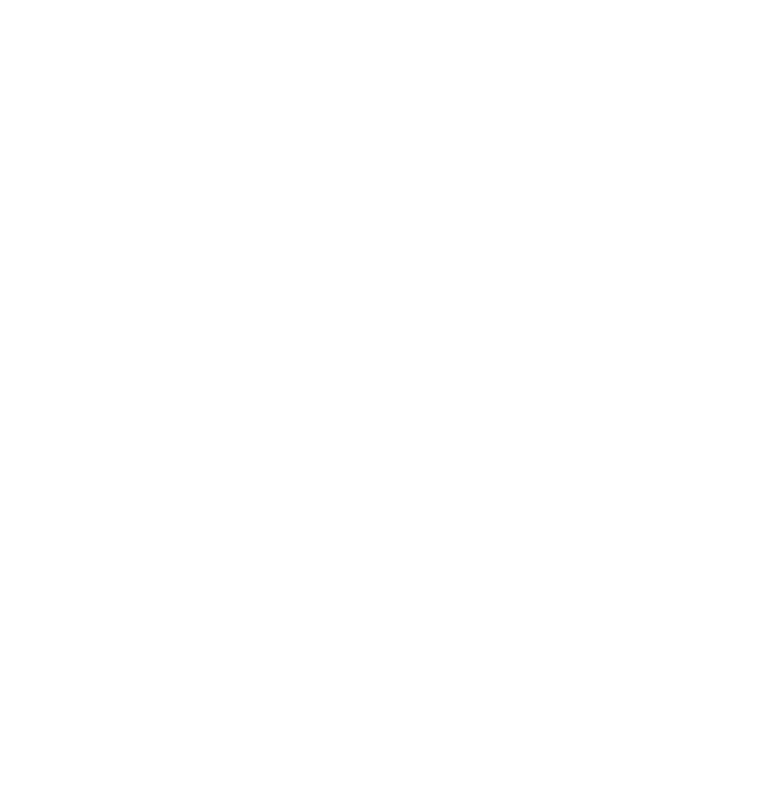

In [61]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, color='white', alpha=.5)
ax.set_axis_off()
plt.show()

## Link streets

In [62]:
buildings = buildings.sjoin_nearest(streets, max_distance=1000, how="left")
buildings.head()

/Users/petrokvartsianyi/opt/miniconda3/envs/kyiv-morphometrics/lib/python3.10/site-packages/geopandas/geodataframe.py:2298: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:5514
Right CRS: EPSG:3857

  return geopandas.sjoin_nearest(


uID                                           geometry  index_right     nID
0    0  POLYGON ((400715.451 -1047066.528, 400798.992 ...       4316.0  4316.0
1    1  POLYGON ((411512.314 -1039314.466, 411523.660 ...       8933.0  8933.0
2    2  POLYGON ((411551.985 -1039399.946, 411563.241 ...       8933.0  8933.0
3    3  POLYGON ((411535.943 -1039300.928, 411574.307 ...       8933.0  8933.0
4    4  POLYGON ((411589.050 -1039278.554, 411600.700 ...       8933.0  8933.0

In [63]:
buildings = buildings.drop_duplicates("uID").drop(columns="index_right")
tessellation = tessellation.merge(buildings[['uID', 'nID']], on='uID', how='left')

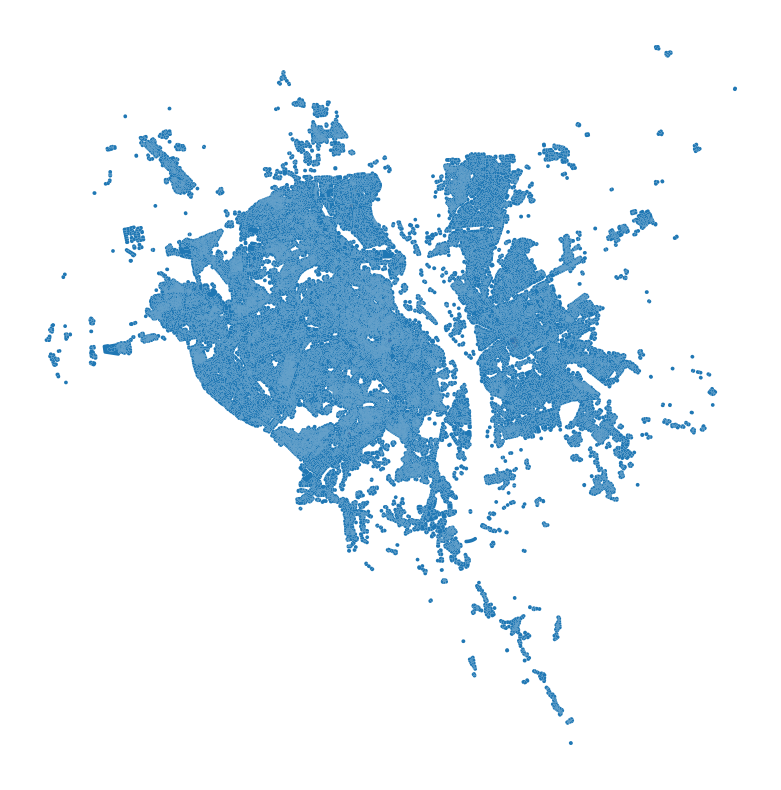

In [64]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax)
ax.set_axis_off()
plt.show()

# Measure

## Dimensions

In [65]:
buildings["area"] = buildings.area
tessellation["area"] = tessellation.area
streets["length"] = streets.length

## Shape

In [66]:
buildings['eri'] = momepy.EquivalentRectangularIndex(buildings).series
buildings['elongation'] = momepy.Elongation(buildings).series
tessellation['convexity'] = momepy.Convexity(tessellation).series
streets["linearity"] = momepy.Linearity(streets).series

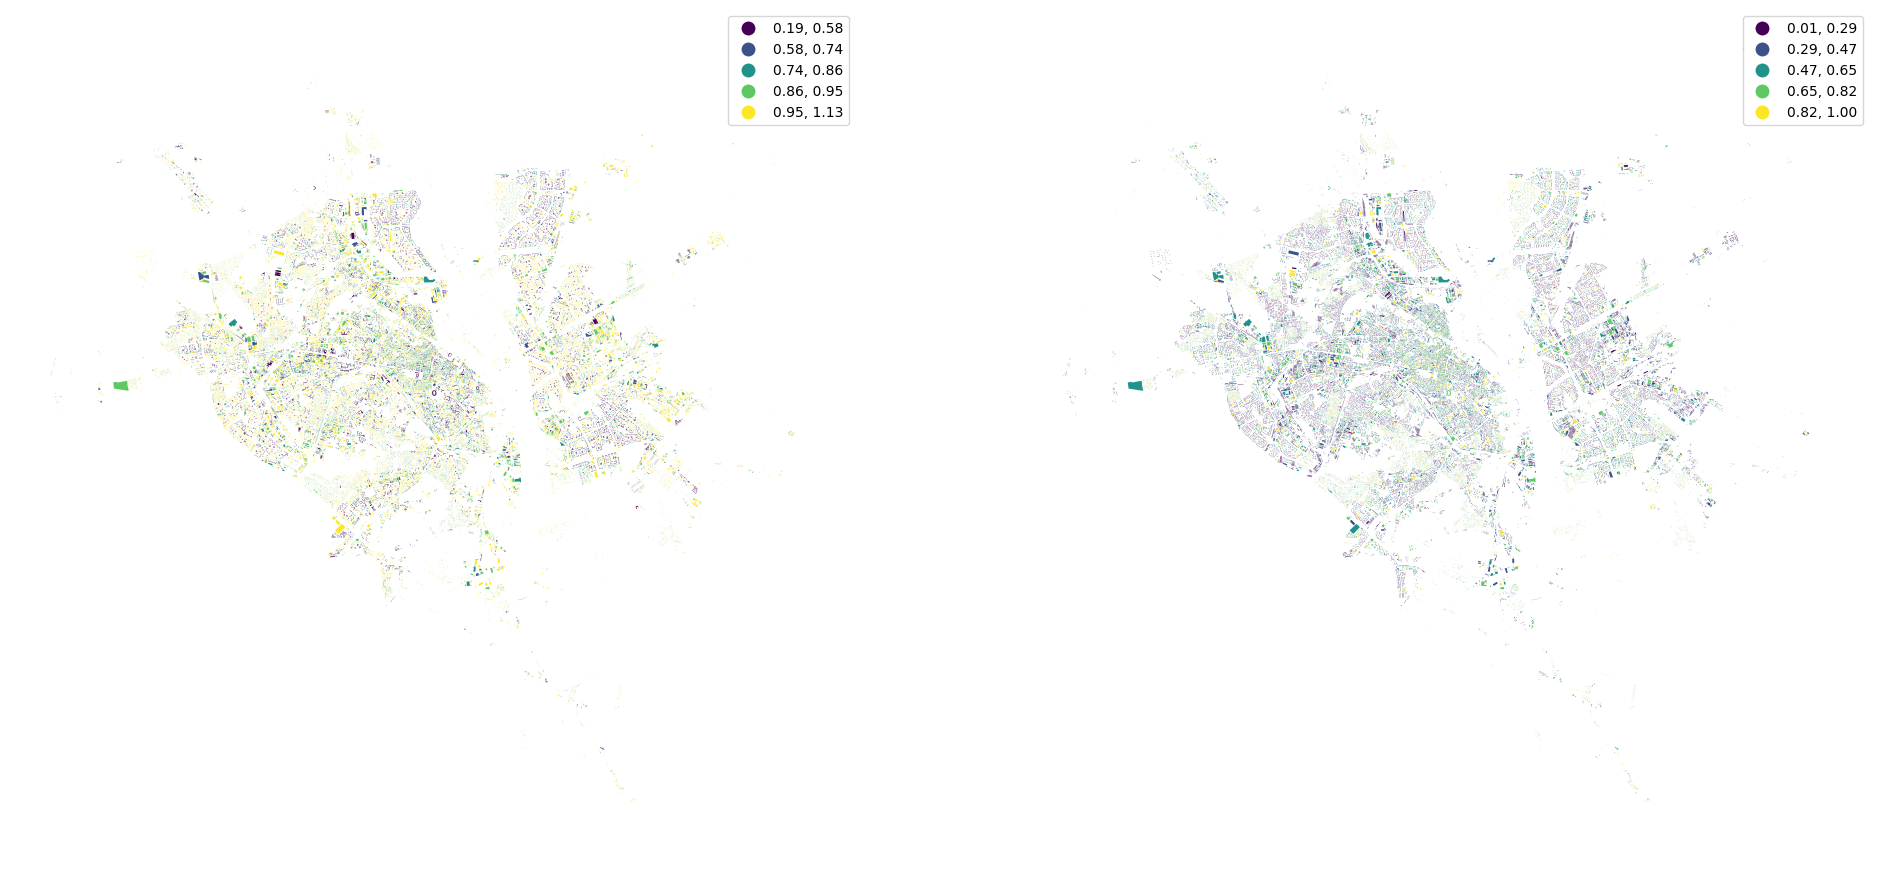

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("eri", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("elongation", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

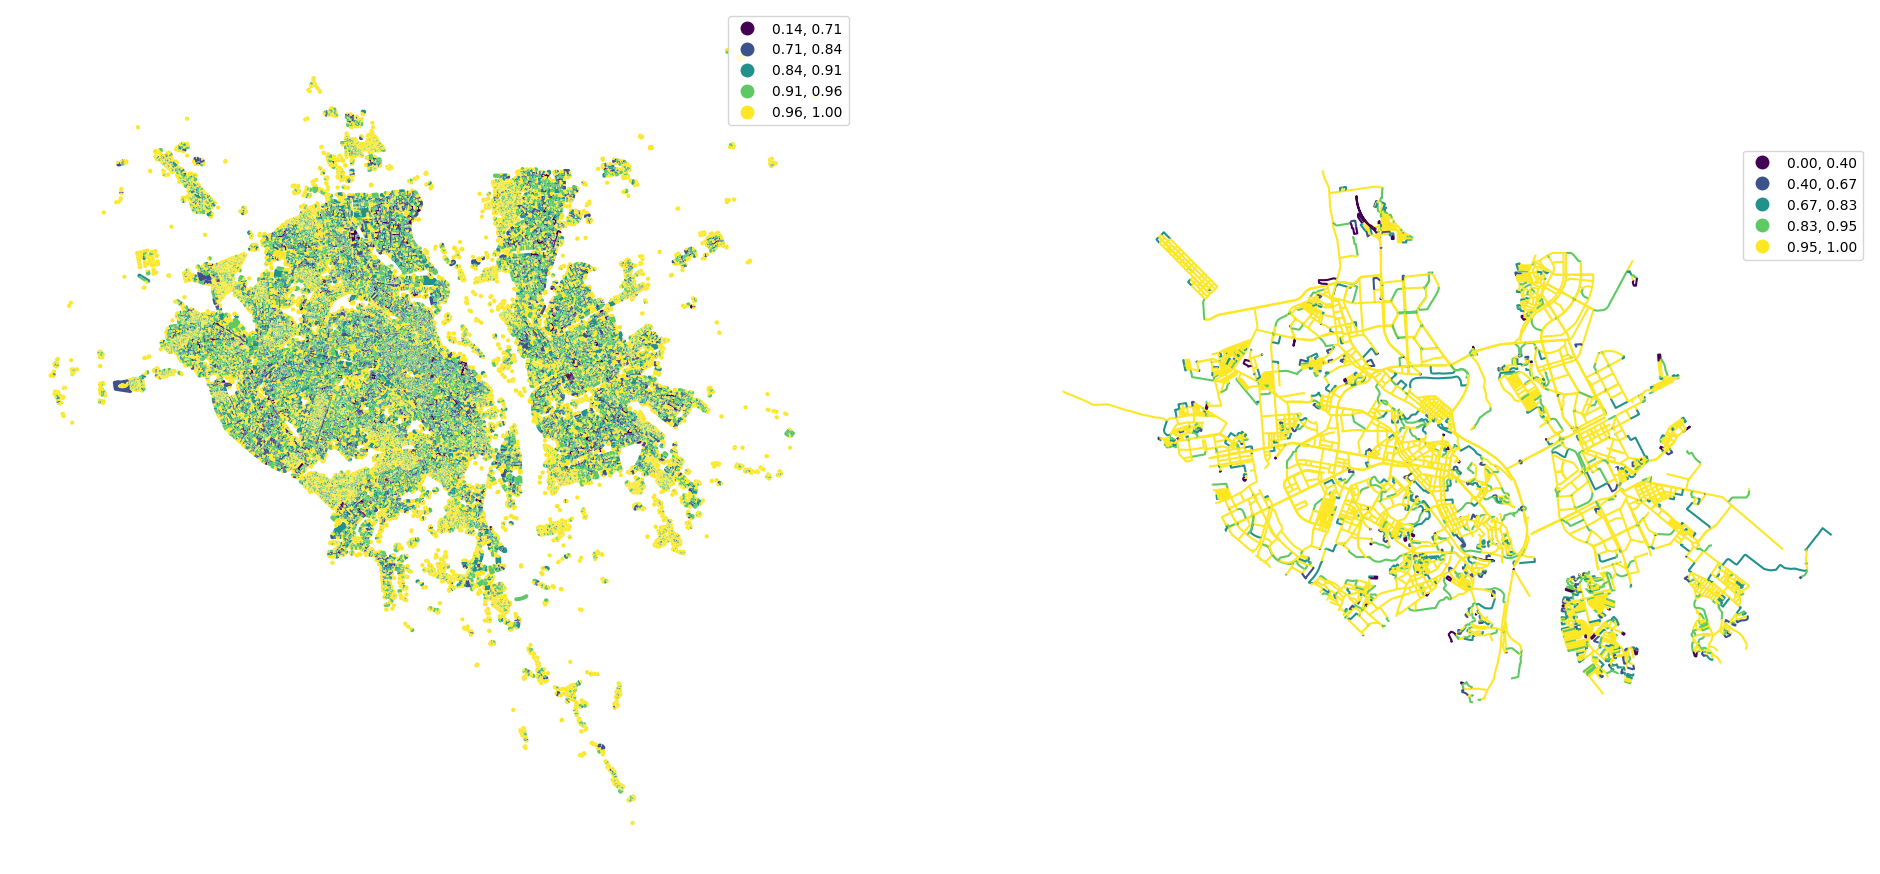

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("linearity", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

## Spatial distribution

/Users/petrokvartsianyi/opt/miniconda3/envs/kyiv-morphometrics/lib/python3.10/site-packages/momepy/distribution.py:135: FutureWarning: The `query_bulk()` method is deprecated and will be removed in GeoPandas 1.0. You can use the `query()` method instead.
  inp, res = gdf.sindex.query_bulk(gdf.geometry, predicate="intersects")


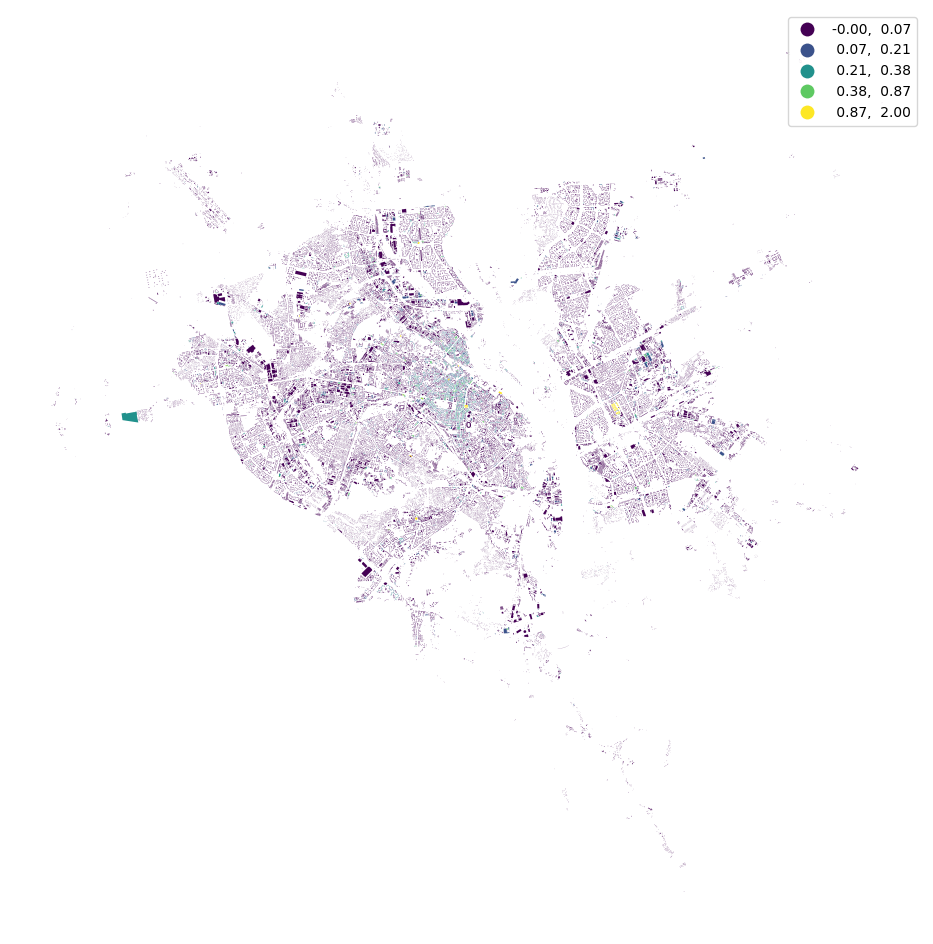

In [73]:
buildings["shared_walls"] = momepy.SharedWallsRatio(buildings).series
buildings.plot("shared_walls", figsize=(12, 12), scheme="natural_breaks", legend=True).set_axis_off()

In [74]:
queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tessellation, ids="uID", silence_warnings=True)

In [75]:
tessellation["neighbors"] = momepy.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
tessellation["covered_area"] = momepy.CoveredArea(tessellation, queen_1, "uID", verbose=False).series

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    buildings["neighbor_distance"] = momepy.NeighborDistance(buildings, queen_1, "uID", verbose=False).series

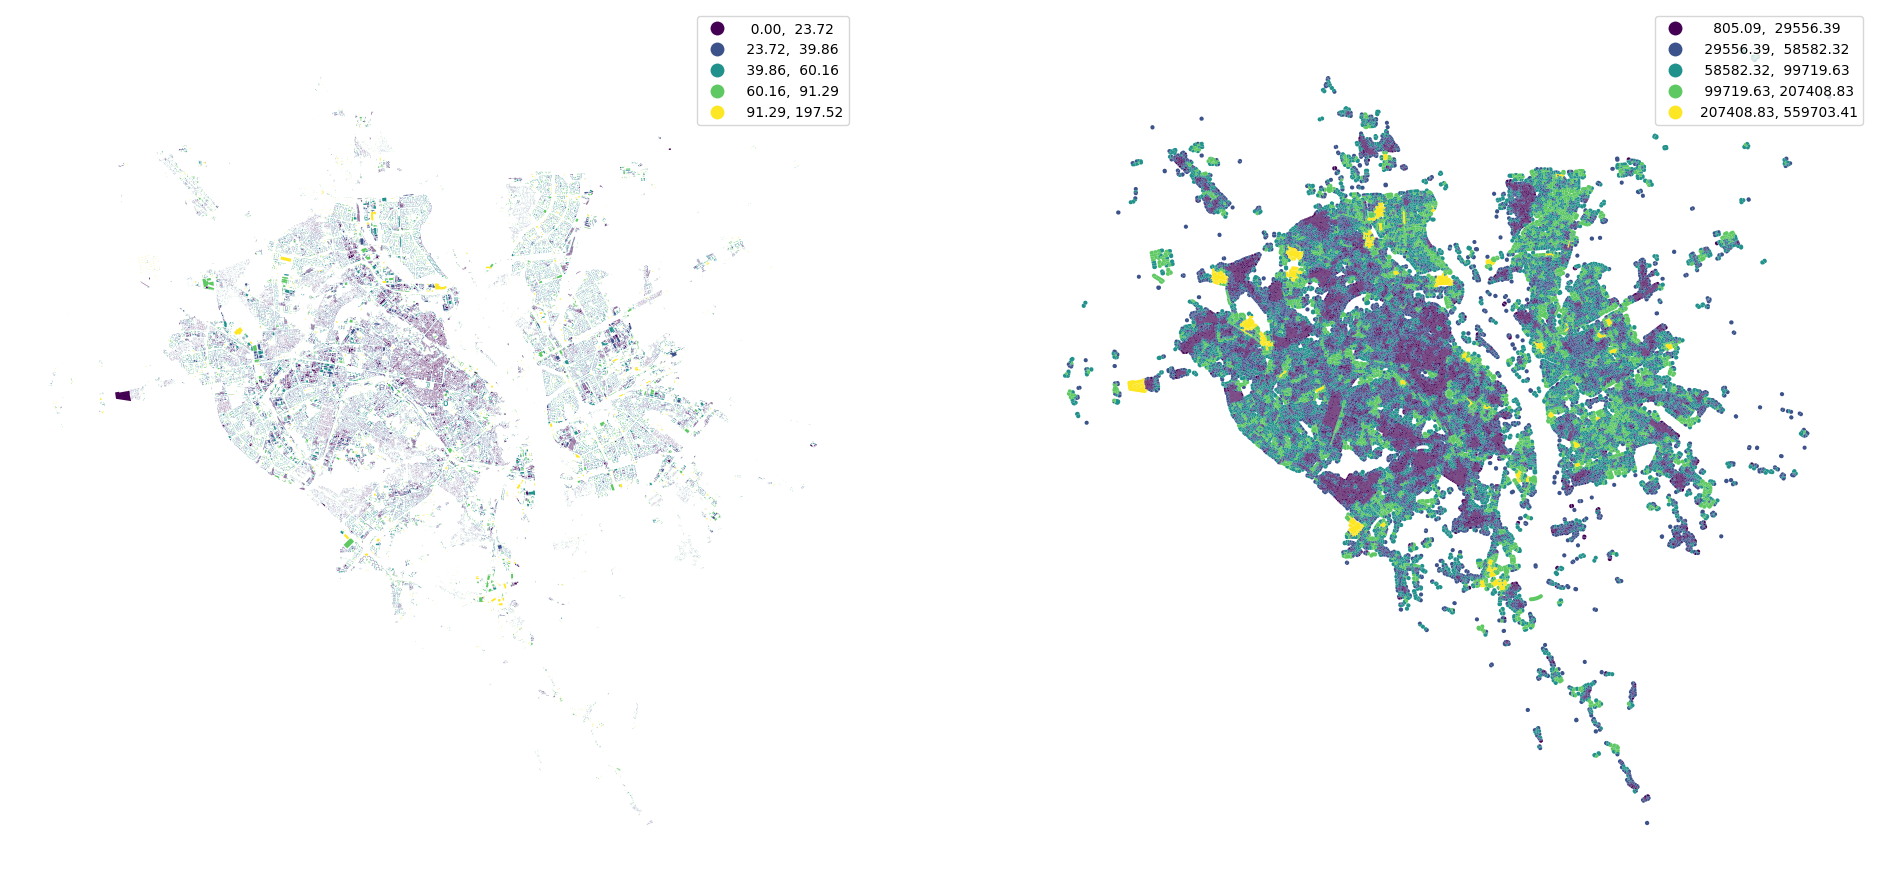

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("neighbor_distance", ax=ax[0], scheme="natural_breaks", legend=True)
tessellation.plot("covered_area", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [78]:
queen_3 = momepy.sw_high(k=3, weights=queen_1)
buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)

buildings['interbuilding_distance'] = momepy.MeanInterbuildingDistance(buildings, queen_1, 'uID', queen_3, verbose=False).series
buildings['adjacency'] = momepy.BuildingAdjacency(buildings, queen_3, 'uID', buildings_q1, verbose=False).series

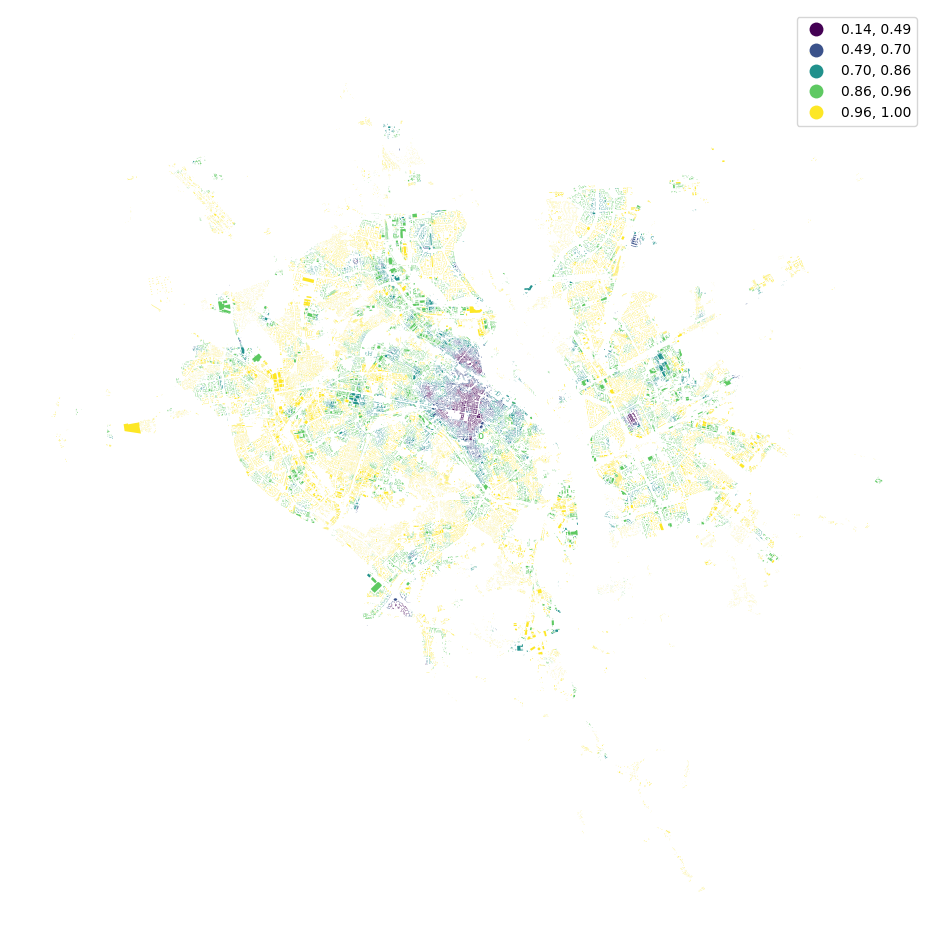

In [86]:
# fig, ax = plt.subplots(1, 2, figsize=(24, 12))

# buildings.plot("interbuilding_distance", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("adjacency", figsize=(12, 12), scheme="natural_breaks", legend=True).set_axis_off()
# ax[0].set_axis_off()
# ax[1].set_axis_off()

In [89]:
profile = momepy.StreetProfile(streets, buildings)

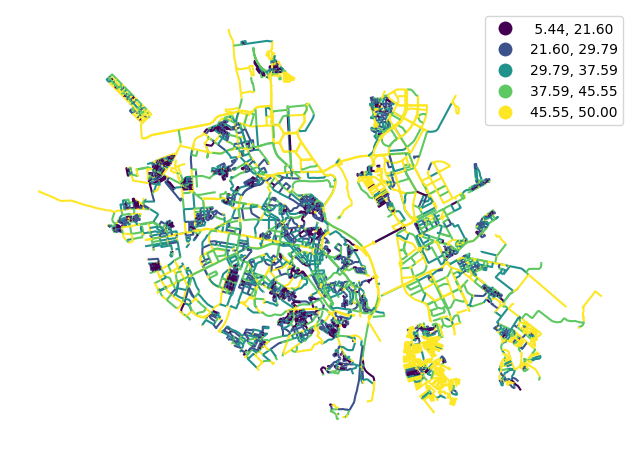

In [98]:
name = "width"
streets[name] = profile.w

fig, ax = plt.subplots(figsize=(8, 6))
streets.plot(name, ax=ax, scheme="natural_breaks", legend=True)
ax.set_axis_off()
fig.savefig("../maps/streets_" + name + ".png", bbox_inches="tight", pad_inches=0.1)
plt.show()
plt.close(fig)

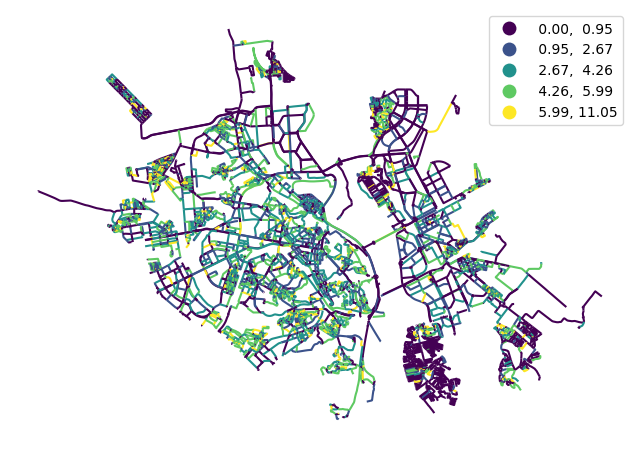

In [99]:
name = "width_deviation"
streets[name] = profile.wd
fig, ax = plt.subplots(figsize=(8, 6))
streets.plot(name, ax=ax, scheme="natural_breaks", legend=True)
ax.set_axis_off()
fig.savefig("../maps/streets_" + name + ".png", bbox_inches="tight", pad_inches=0.1)
plt.show()
plt.close(fig)

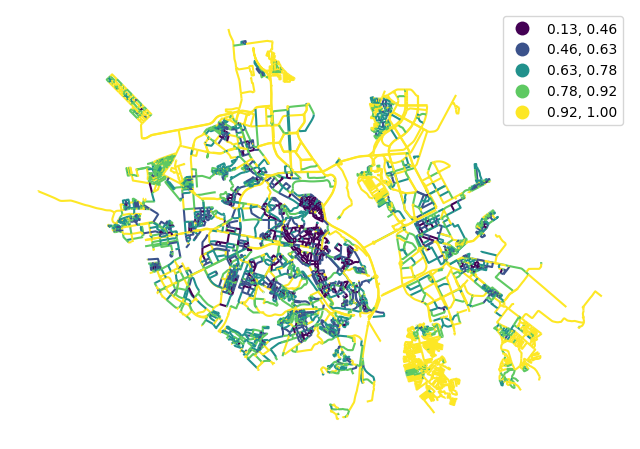

In [100]:
name = "openness"
streets[name] = profile.o
fig, ax = plt.subplots(figsize=(8, 6))
streets.plot(name, ax=ax, scheme="natural_breaks", legend=True)
ax.set_axis_off()
fig.savefig("../maps/streets_" + name + ".png", bbox_inches="tight", pad_inches=0.1)
plt.show()
plt.close(fig)

## Intensity

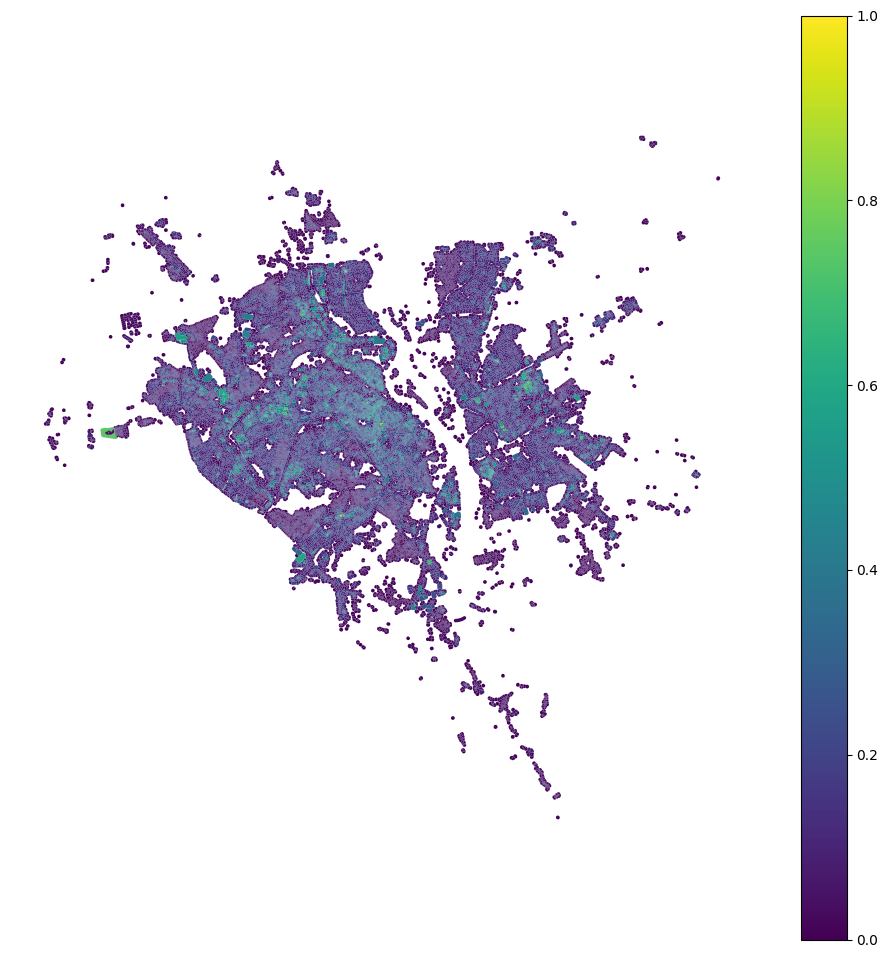

In [102]:
fig, ax = plt.subplots(figsize=(12, 12))
tessellation.plot("car", ax=ax, vmin=0, vmax=1, legend=True)
ax.set_axis_off()

# Save the plot as a PNG image
output_file = "tessellation_intensity_area_ratio.png"
plt.savefig("../maps/"+output_file, bbox_inches="tight", pad_inches=0.1)
plt.show()

## Connectivity

In [103]:
graph = momepy.gdf_to_nx(streets)
graph = momepy.node_degree(graph)
graph = momepy.closeness_centrality(graph, radius=400, distance="mm_len")
graph = momepy.meshedness(graph, radius=400, distance="mm_len")
nodes, streets = momepy.nx_to_gdf(graph)

  0%|          | 0/6223 [00:00<?, ?it/s]

  0%|          | 0/6223 [00:00<?, ?it/s]

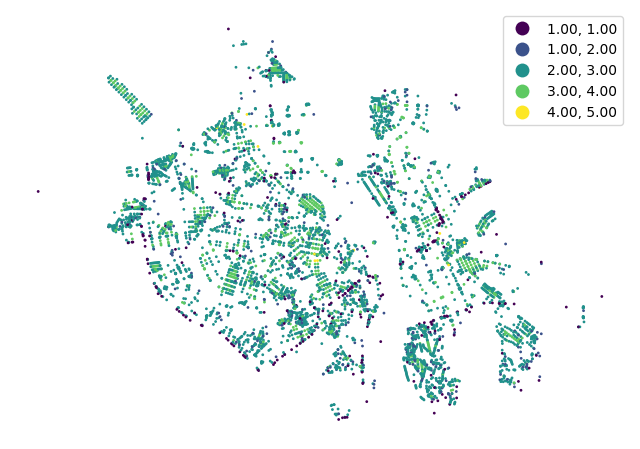

In [109]:
name = "degree"

fig, ax = plt.subplots(figsize=(8, 6))
nodes.plot(name, ax=ax, scheme="natural_breaks", legend=True, markersize=1)
ax.set_axis_off()
fig.savefig("../maps/connectivity_" + name + ".png", bbox_inches="tight", pad_inches=0.1)
plt.show()
plt.close(fig)

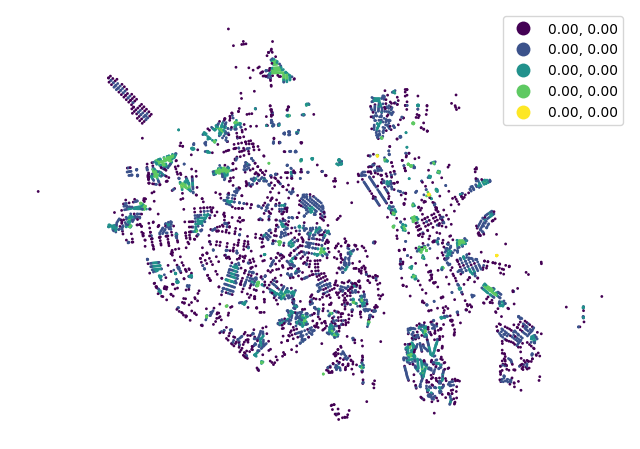

In [110]:
name = "closeness"

fig, ax = plt.subplots(figsize=(8, 6))
nodes.plot(name, ax=ax, scheme="natural_breaks", legend=True, markersize=1)
ax.set_axis_off()
fig.savefig("../maps/connectivity_" + name + ".png", bbox_inches="tight", pad_inches=0.1)
plt.show()
plt.close(fig)

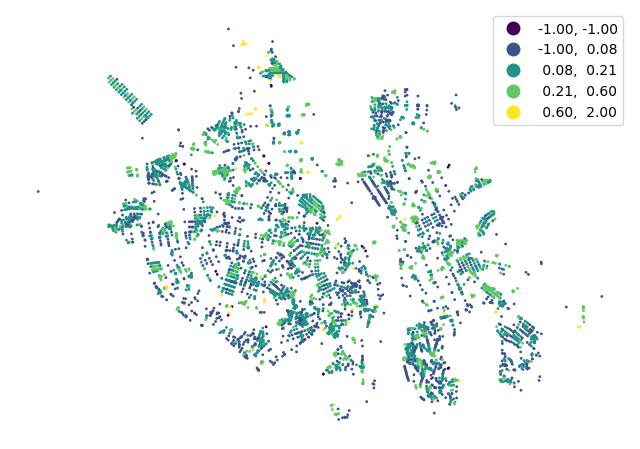

In [111]:
name = "meshedness"

fig, ax = plt.subplots(figsize=(8, 6))
nodes.plot(name, ax=ax, scheme="natural_breaks", legend=True, markersize=1)
ax.set_axis_off()
fig.savefig("../maps/connectivity_" + name + ".png", bbox_inches="tight", pad_inches=0.1)
plt.show()
plt.close(fig)

In [112]:
buildings["nodeID"] = momepy.get_node_id(buildings, nodes, streets, "nodeID", "nID")

  0%|          | 0/59278 [00:00<?, ?it/s]

In [113]:
# Link all data together (to tessellation cells or buildings).

merged = tessellation.merge(buildings.drop(columns=['nID', 'geometry']), on='uID')
merged = merged.merge(streets.drop(columns='geometry'), on='nID', how='left')
merged = merged.merge(nodes.drop(columns='geometry'), on='nodeID', how='left')
merged.columns

Index(['uID', 'geometry', 'nID', 'area_x', 'convexity', 'neighbors',
       'covered_area', 'car', 'area_y', 'eri', 'elongation', 'shared_walls',
       'neighbor_distance', 'interbuilding_distance', 'adjacency', 'nodeID',
       'length', 'linearity', 'width', 'width_deviation', 'openness', 'mm_len',
       'node_start', 'node_end', 'degree', 'closeness', 'meshedness'],
      dtype='object')

# Understanding the context

In [114]:
# Measure first, second and third quartile of distribution of values within an area around each building.
percentiles = []
for column in merged.columns.drop(["uID", "nodeID", "nID", 'mm_len', 'node_start', 'node_end', "geometry"]):
    perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
    perc.columns = [f"{column}_" + str(x) for x in perc.columns]
    percentiles.append(perc)

In [115]:
percentiles_joined = pandas.concat(percentiles, axis=1)
percentiles_joined.head()

area_x_25     area_x_50     area_x_75  convexity_25  convexity_50  \
0  39802.278366  39802.278366  39802.278366      0.999965      0.999965   
1   2564.702101   3999.754301  10462.207725      0.946044      0.958392   
2   2564.702101   4590.891819  12026.339655      0.946044      0.956165   
3  10565.228981  11878.387906  17149.101644      0.968101      0.986677   
4   2204.747580   3171.369192   9910.722226      0.937836      0.977670   

   convexity_75  neighbors_25  neighbors_50  neighbors_75  covered_area_25  \
0      0.999965      0.000000      0.000000      0.000000     39802.278366   
1      0.972173      0.011092      0.015422      0.027245     26859.084362   
2      0.967088      0.009186      0.013662      0.028589     27049.679848   
3      0.994536      0.005823      0.006989      0.008716     58493.281172   
4      0.987824      0.013009      0.019730      0.023826     26188.982511   

   ...  openness_75  degree_25  degree_50  degree_75  closeness_25  \
0  ...          NaN        NaN        NaN        NaN           NaN   
1  ...          NaN        NaN        NaN        NaN           NaN   
2  ...          NaN        NaN        NaN        NaN           NaN   
3  ...          NaN        NaN        NaN        NaN           NaN   
4  ...          NaN        NaN        NaN        NaN           NaN   

   closeness_50  closeness_75  meshedness_25  meshedness_50  meshedness_75  
0           NaN           NaN            NaN            NaN            NaN  
1           NaN           NaN            NaN            NaN            NaN  
2           NaN           NaN            NaN            NaN            NaN  
3           NaN           NaN            NaN            NaN            NaN  
4           NaN           NaN            NaN            NaN            NaN  

[5 rows x 60 columns]

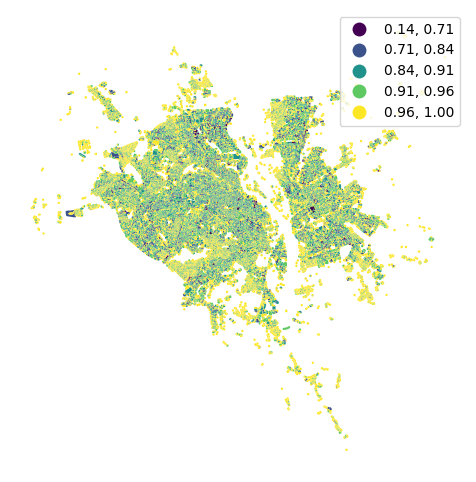

In [119]:
fig, ax = plt.subplots(figsize=(8, 6))
tessellation.plot("convexity", ax=ax, scheme="natural_breaks", legend=True)
ax.set_axis_off()
fig.savefig("../maps/tesselation_convexity" + ".png", bbox_inches="tight", pad_inches=0.1)
plt.show()
plt.close(fig)

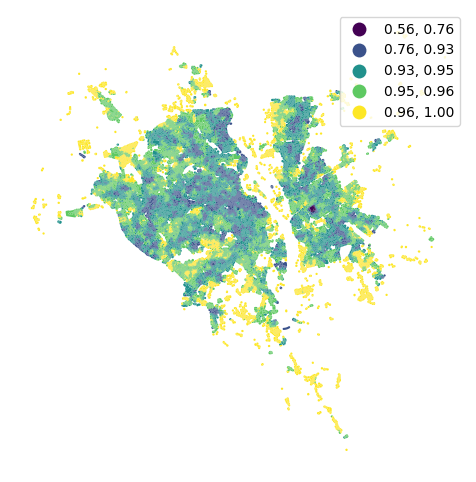

In [120]:
fig, ax = plt.subplots(figsize=(8, 6))
merged.plot(percentiles_joined['convexity_50'].values, ax=ax, scheme="natural_breaks", legend=True)
ax.set_axis_off()
fig.savefig("../maps/spatially_lagged_convexity" + ".png", bbox_inches="tight", pad_inches=0.1)
plt.show()
plt.close(fig)

# Clustering

In [121]:
standardized = (percentiles_joined - percentiles_joined.mean()) / percentiles_joined.std()
standardized.head()

area_x_25  area_x_50  area_x_75  convexity_25  convexity_50  convexity_75  \
0  13.082876   9.683694   6.346401      2.717135      2.524814      2.628012   
1  -0.093899  -0.163067   0.565894      1.118891      0.491023     -0.071973   
2  -0.093899  -0.000487   0.874055      1.118891      0.382086     -0.566009   
3   2.737143   2.003792   1.883329      1.772690      1.874758      2.100655   
4  -0.221272  -0.390898   0.457242      0.875620      1.434148      1.448533   

   neighbors_25  neighbors_50  neighbors_75  covered_area_25  ...  \
0     -2.579765     -2.815049     -3.035398         0.721604  ...   
1     -1.071764     -0.987388     -0.204281        -0.061583  ...   
2     -1.330931     -1.195940     -0.064563        -0.050050  ...   
3     -1.788098     -1.986805     -2.129733         1.852588  ...   
4     -0.811211     -0.476936     -0.559596        -0.102131  ...   

   openness_75  degree_25  degree_50  degree_75  closeness_25  closeness_50  \
0          NaN        NaN        NaN        NaN           NaN           NaN   
1          NaN        NaN        NaN        NaN           NaN           NaN   
2          NaN        NaN        NaN        NaN           NaN           NaN   
3          NaN        NaN        NaN        NaN           NaN           NaN   
4          NaN        NaN        NaN        NaN           NaN           NaN   

   closeness_75  meshedness_25  meshedness_50  meshedness_75  
0           NaN            NaN            NaN            NaN  
1           NaN            NaN            NaN            NaN  
2           NaN            NaN            NaN            NaN  
3           NaN            NaN            NaN            NaN  
4           NaN            NaN            NaN            NaN  

[5 rows x 60 columns]

In [122]:
cgram = Clustergram(range(1, 12), n_init=10, random_state=42)
cgram.fit(standardized.fillna(0))

show(cgram.bokeh())

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.385 seconds.
K=3 fitted in 0.942 seconds.
K=4 fitted in 0.442 seconds.
K=5 fitted in 0.587 seconds.
K=6 fitted in 0.760 seconds.
K=7 fitted in 1.130 seconds.
K=8 fitted in 1.032 seconds.
K=9 fitted in 1.241 seconds.
K=10 fitted in 1.467 seconds.
K=11 fitted in 1.798 seconds.


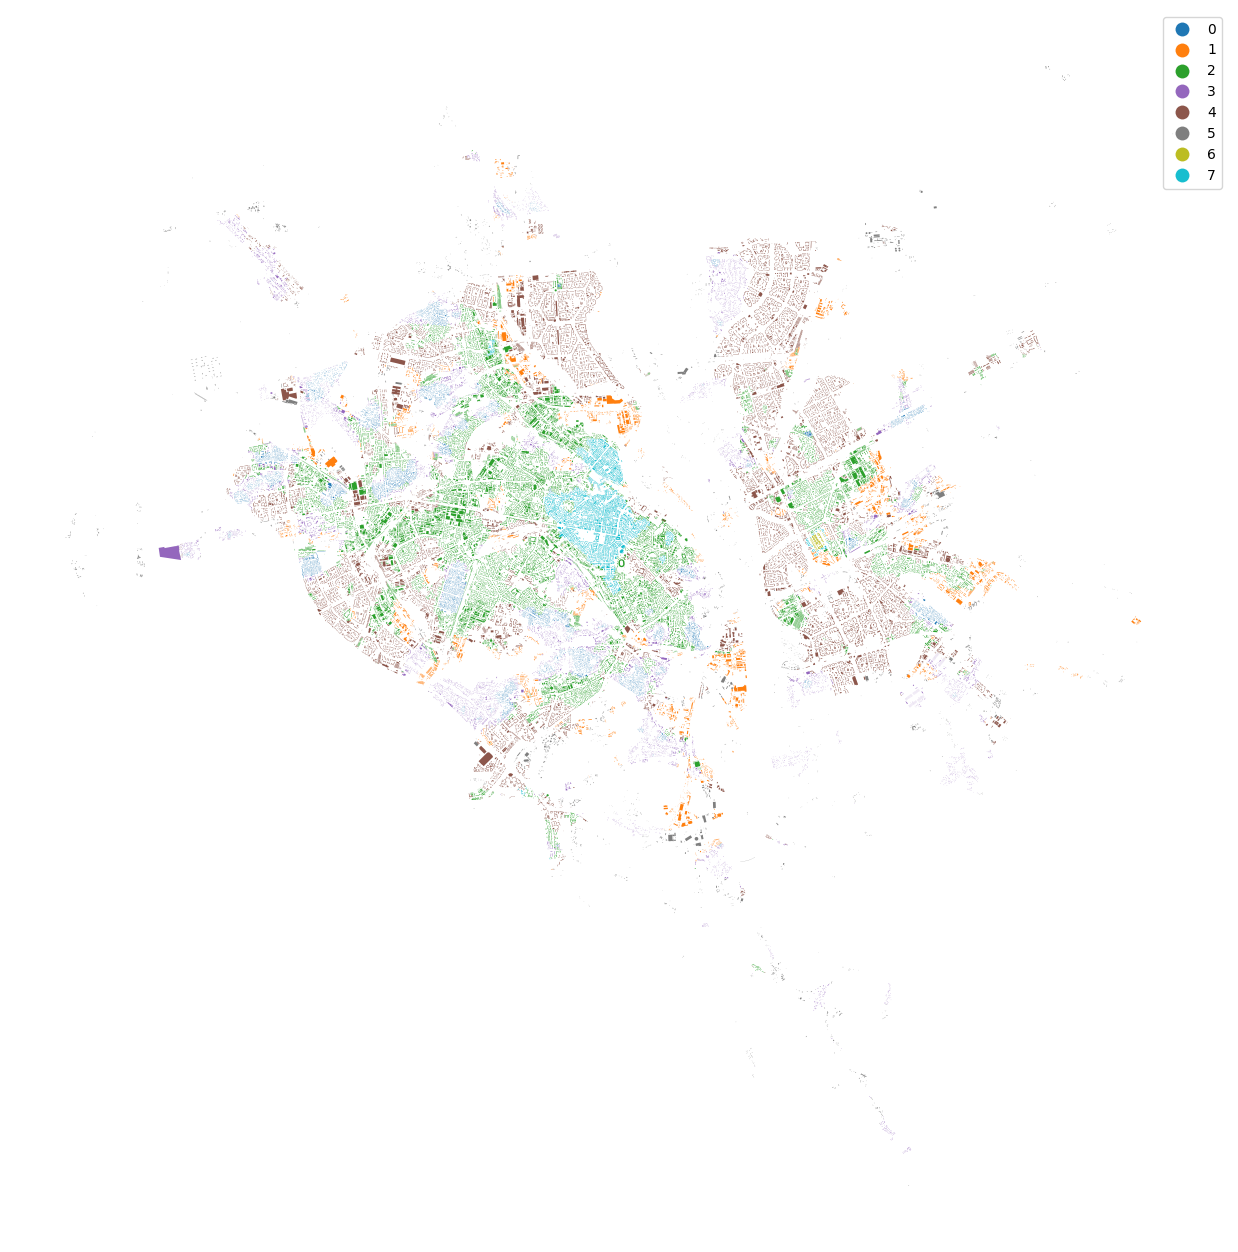

In [126]:
fig, ax = plt.subplots(figsize=(16, 16))

merged["cluster"] = cgram.labels[8].values
urban_types = buildings[["geometry", "uID"]].merge(merged[["uID", "cluster"]], on="uID")
urban_types.plot("cluster", categorical=True, ax=ax, legend=True)

ax.set_axis_off()
fig.savefig("../maps/cluster_urban_types" + ".png", bbox_inches="tight", pad_inches=0.1)
plt.show()
plt.close(fig)

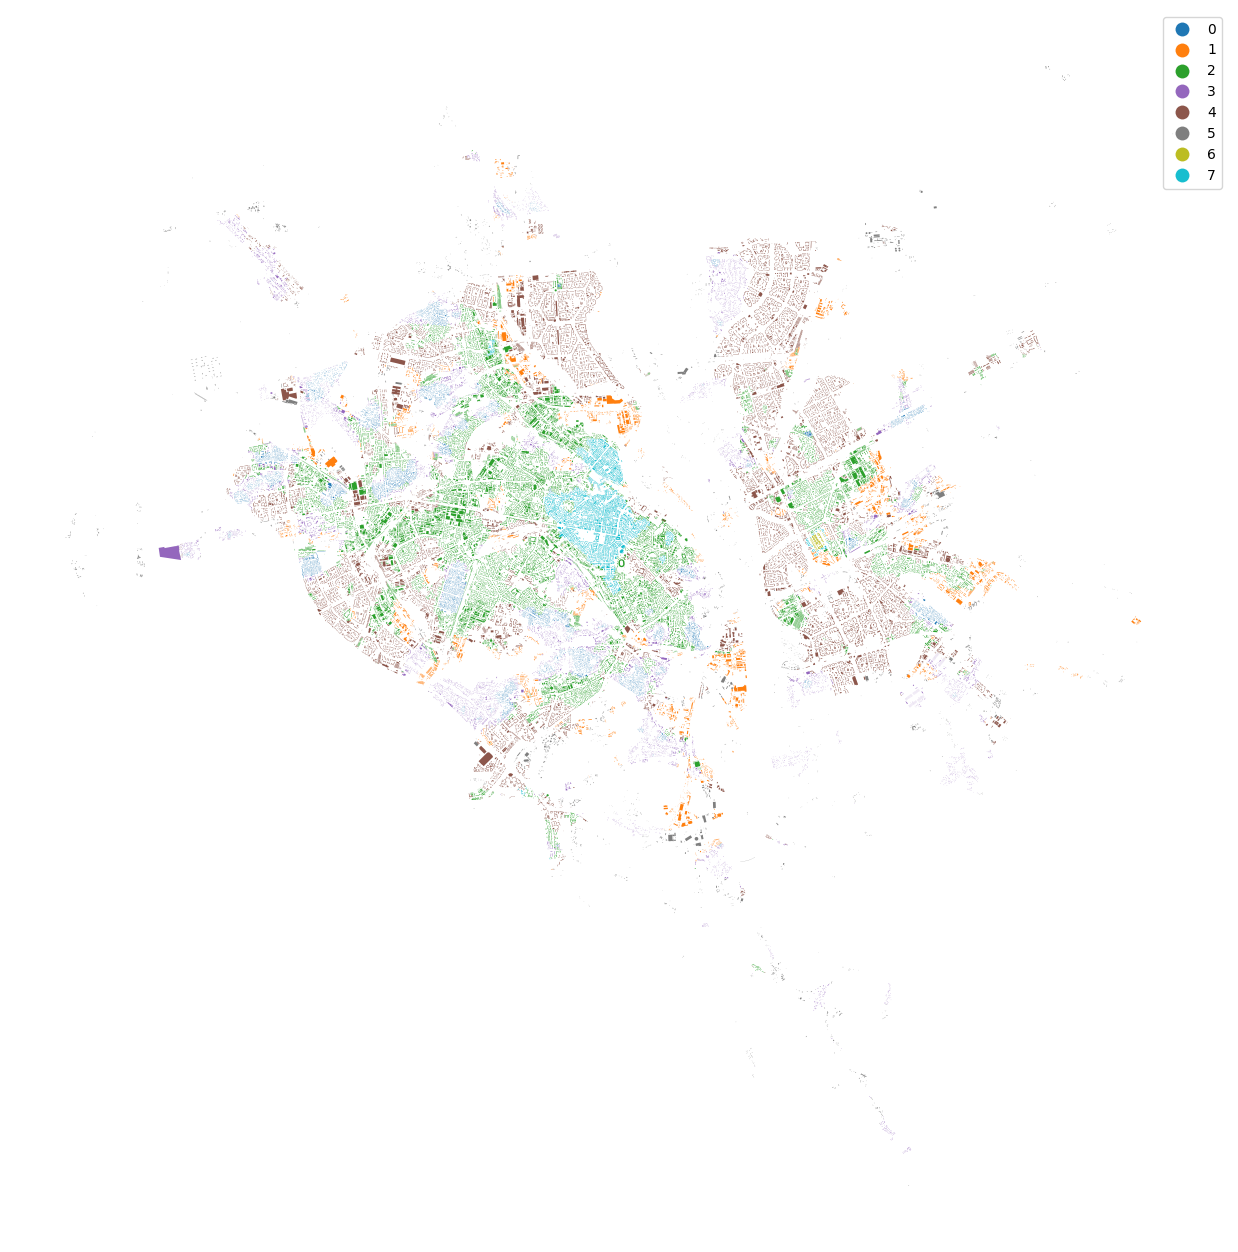

In [40]:
ax = urban_types.plot("cluster", categorical=True, figsize=(16, 16), legend=True)
# ax.set_xlim(-645000, -641000)
# ax.set_ylim(-1195500, -1191000)
ax.set_axis_off()